In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from tqdm import tqdm
from cell_paint_seg.utils import get_id_to_path
from cell_paint_seg.image_io import read_ims, read_seg
from skimage import exposure
import umap
import umap.plot
from graspologic.plot import heatmap
import pickle

/Users/thomasathey/Documents/shavit-lab/fraenkel/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/thomasathey/Documents/shavit-lab/fraenkel/.venv/lib/python3.9/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Users/thomasathey/Documents/shavit-lab/fraenkel/.venv/lib/python3.9/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, erro

In [2]:
channels = ["Brightfield", "ER", "AGP", "Mito", "DNA", "RNA"]

# Image averages

## Get data

In [3]:
data_paths = [
    "/Users/thomasathey/Documents/shavit-lab/fraenkel/first-sample/Assay Dev 20230329/BR00142687__2024-03-29T18_18_57-Measurement 1/stats/Image.csv",
    "/Users/thomasathey/Documents/shavit-lab/fraenkel/first-sample/Assay Dev 20230329/BR00142688__2024-03-29T19_57_13-Measurement 1/stats/Image.csv",
]

In [4]:
feats_to_exclude = [
    "Metadata_Series",
    "Metadata_Site",
    "Metadata_Well",
    "Metadata_WellColumn",
    "Metadata_WellRow",
    "AreaShape_Orientation",
    "AreaShape_BoundingBoxMaximum_X",
    "AreaShape_BoundingBoxMaximum_Y",
    "AreaShape_BoundingBoxMinimum_X",
    "AreaShape_BoundingBoxMinimum_Y",
    "AreaShape_Center_X",
    "AreaShape_Center_Y",
    "Children_Cytoplasm_Count",
    "Location_CenterMassIntensity_X_scaled_AGP",
    "Location_CenterMassIntensity_Y_scaled_AGP",
    "Location_CenterMassIntensity_Z_scaled_AGP",
    "Location_CenterMassIntensity_X_scaled_DNA",
    "Location_CenterMassIntensity_Y_scaled_DNA",
    "Location_CenterMassIntensity_Z_scaled_DNA",
    "Location_CenterMassIntensity_X_scaled_ER",
    "Location_CenterMassIntensity_Y_scaled_ER",
    "Location_CenterMassIntensity_Z_scaled_ER",
    "Location_CenterMassIntensity_X_scaled_mito",
    "Location_CenterMassIntensity_Y_scaled_mito",
    "Location_CenterMassIntensity_Z_scaled_mito",
    "Location_CenterMassIntensity_X_scaled_RNA",
    "Location_CenterMassIntensity_Y_scaled_RNA",
    "Location_CenterMassIntensity_Z_scaled_RNA",
    "Location_MaxIntensity_X_scaled_DNA",
    "Location_MaxIntensity_X_scaled_AGP",
    "Location_MaxIntensity_X_scaled_mito",
    "Location_MaxIntensity_X_scaled_ER",
    "Location_Center_X",
    "Location_Center_Y",
    "Location_MaxIntensity_X_scaled_RNA",
    "Location_MaxIntensity_Y_scaled_DNA",
    "Location_MaxIntensity_Y_scaled_AGP",
    "Location_MaxIntensity_Y_scaled_mito",
    "Location_MaxIntensity_Y_scaled_ER",
    "Location_MaxIntensity_Y_scaled_RNA",
    "Location_MaxIntensity_Z_scaled_DNA",
    "Location_MaxIntensity_Z_scaled_AGP",
    "Location_MaxIntensity_Z_scaled_mito",
    "Location_MaxIntensity_Z_scaled_ER",
    "Location_MaxIntensity_Z_scaled_RNA",
    "Neighbors_AngleBetweenNeighbors_Adjacent",
    "Neighbors_AngleBetweenNeighbors_25",
    "Neighbors_FirstClosestObjectNumber_Adjacent",
    "Neighbors_SecondClosestObjectNumber_Adjacent",
    "Number_Object_Number",
    "Parent_EdgeNuclei",
    "Parent_Nuclei",
    "Neighbors_FirstClosestObjectNumber_25",
    "Neighbors_SecondClosestObjectNumber_25",
]


def include_feat(feat_name):
    for feat_to_exclude in feats_to_exclude:
        if feat_to_exclude in feat_name:
            return False
    return True


dfs = []
for i, data_path in enumerate(data_paths):
    df = pd.read_csv(data_path)

    row = [int(fname[1:3]) for fname in list(df["FileName_AGP"])]
    col = [int(fname[4:6]) for fname in list(df["FileName_AGP"])]
    well = [(i, r, c) for r, c in zip(row, col)]
    field = [int(fname[7:9]) for fname in list(df["FileName_AGP"])]
    id = [fname[:12] for fname in list(df["FileName_AGP"])]

    df["Row"] = row
    df["Column"] = col
    df["Well"] = well
    df["Field"] = field
    df["ID"] = id

    col_names = list(df.columns)
    col_names = [col_name for col_name in col_names if "Mean_" in col_name]
    col_names = [col_name for col_name in col_names if include_feat(col_name)]
    col_names += ["Plate", "Row", "Column", "Well", "Field", "ID"]
    print(f"{len(col_names)} different features")
    df["Plate"] = i
    dfs.append(df[col_names])
df_means = pd.concat(dfs, axis="rows")

1183 different features
1183 different features


In [5]:
df_conditions = pd.read_excel(
    "/Users/thomasathey/Documents/shavit-lab/fraenkel/first-sample/Assay Dev 20230329/Answer ALS_Pilot2_March2024.xlsx"
)
df_conditions = df_conditions.iloc[:16, 2:]

data_dmso = []
data_autophagy = []
data_verdinexor = []
data_h2o2 = []
data_tunicamycin = []
data_importazole = []
data_celltype = []

for i, row in df_means.iterrows():
    r = row["Row"] - 1
    c = row["Column"] - 1
    p = row["Plate"]

    condition = df_conditions.iloc[r, c]

    if c % 6 == 0:
        data_dmso.append(1)
        data_autophagy.append(0)
        data_verdinexor.append(0)
        data_h2o2.append(0)
        data_tunicamycin.append(0)
        data_importazole.append(0)
    elif c % 6 == 1:
        data_dmso.append(0)
        data_autophagy.append(1)
        data_verdinexor.append(0)
        data_h2o2.append(0)
        data_tunicamycin.append(0)
        data_importazole.append(0)
    elif c % 6 == 2:
        data_dmso.append(0)
        data_autophagy.append(0)
        data_verdinexor.append(float(condition))
        data_h2o2.append(0)
        data_tunicamycin.append(0)
        data_importazole.append(0)
    elif c % 6 == 3:
        data_dmso.append(0)
        data_autophagy.append(0)
        data_verdinexor.append(0)
        data_h2o2.append(float(condition))
        data_tunicamycin.append(0)
        data_importazole.append(0)
    elif c % 6 == 4:
        data_dmso.append(0)
        data_autophagy.append(0)
        data_verdinexor.append(0)
        data_h2o2.append(0)
        data_tunicamycin.append(float(condition))
        data_importazole.append(0)
    elif c % 6 == 5:
        data_dmso.append(0)
        data_autophagy.append(0)
        data_verdinexor.append(0)
        data_h2o2.append(0)
        data_tunicamycin.append(0)
        data_importazole.append(float(condition))

    if p == 0:
        if (r < 8 and c < 6) or (r >= 8 and c >= 18):
            data_celltype.append("Control 1")
        elif (r < 8 and c >= 6 and c < 12) or (r >= 8 and c < 6):
            data_celltype.append("ALS 1")
        elif (r < 8 and c >= 18) or (r >= 8 and c < 18 and c >= 12):
            data_celltype.append("Control 2")
        else:
            data_celltype.append("ALS 2")
    elif p == 1:
        if (r < 8 and c < 6) or (r >= 8 and c >= 18):
            data_celltype.append("ALS 2")
        elif (r < 8 and c >= 6 and c < 12) or (r >= 8 and c < 6):
            data_celltype.append("Control 2")
        elif (r < 8 and r >= 6 and c >= 18) or (
            r >= 8 and r < 10 and c < 18 and c >= 12
        ):
            data_celltype.append("ALS 1")
        elif (r < 8 and c >= 12 and c < 18) or (r >= 8 and c < 12 and c >= 6):
            data_celltype.append("Control 1")
        else:
            data_celltype.append("EMPTY")


data = {
    "DMSO": data_dmso,
    "Autophagy": data_autophagy,
    "Verdinexor": data_verdinexor,
    "H2O2": data_h2o2,
    "Tunicamysin": data_tunicamycin,
    "Importazole": data_importazole,
    "Cell Type": data_celltype,
}
df_covariates = pd.DataFrame(data)

In [6]:
# why do we need this?
df_covariates.reset_index(drop=True, inplace=True)
df_means.reset_index(drop=True, inplace=True)

In [7]:
df = pd.concat((df_means, df_covariates), axis="columns")

## Compute distance matrix

In [8]:
aggregation_functions = {k: "median" for k in list(df.columns) if "Mean_" in k}
aggregation_functions_2 = {k: "first" for k in list(df.columns) if "Mean_" not in k}
aggregation_functions.update(aggregation_functions_2)
df_agg = df.groupby(df["Well"]).aggregate(aggregation_functions)

df_agg.sort_values(by=["Cell Type"], inplace=True)

col_names = list(df.columns)
col_names = [col_name for col_name in col_names if "Mean_" in col_name]
print(len(col_names))
df_feats_agg = df_agg[col_names]

1177


In [9]:
feats = df_feats_agg.to_numpy()
print(f"Fraction of finite feature values: {np.sum(np.isfinite(feats))/feats.size}")
feats = np.nan_to_num(feats)
D = pairwise_distances(feats, metric="cosine")

Fraction of finite feature values: 0.99565455961484


## Plot distance matrix

<Axes: >

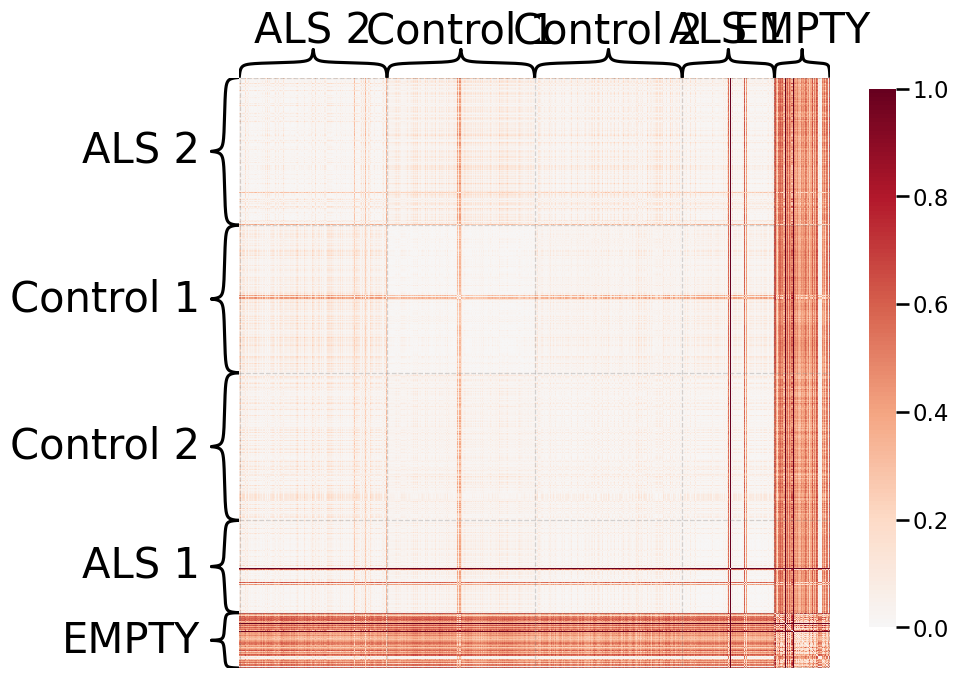

In [10]:
heatmap(D, inner_hier_labels=df_agg["Cell Type"])

/var/folders/gy/jk_d3cx54vj18w9sm6x3sg_80000gn/T/ipykernel_35480/1700584820.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  type1 = cell_types[i]
/var/folders/gy/jk_d3cx54vj18w9sm6x3sg_80000gn/T/ipykernel_35480/1700584820.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  type2 = cell_types[j]


Text(0.5, 1.0, 'Inter vs. Intra Cell Type Feature Distances (Mann-Whitney p-val: 0.00E+00)')

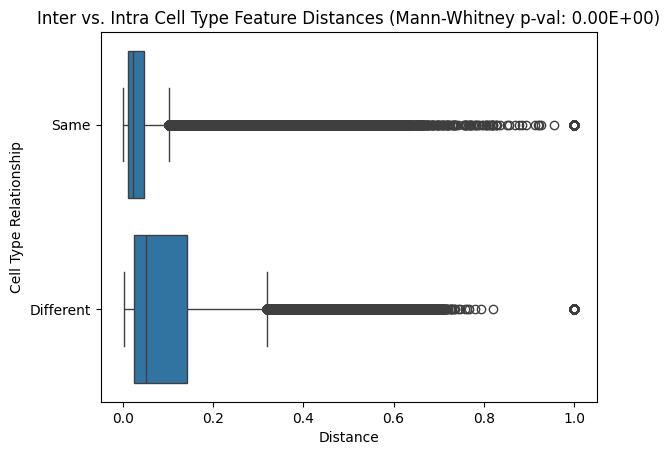

In [11]:
data_dist = []
data_type = []
data_ids = []
cell_types = df_agg["Cell Type"]

for i in range(D.shape[0]):
    type1 = cell_types[i]
    for j in range(i):
        type2 = cell_types[j]
        data_dist.append(D[i, j])
        data_ids.append((id[i], id[j]))
        if type1 == type2:
            data_type.append("Same")
        else:
            data_type.append("Different")

df_types = pd.DataFrame(
    data={
        "Distance": data_dist,
        "Cell Type Relationship": data_type,
        "ID Pair": data_ids,
    }
)
sns.boxplot(df_types, x="Distance", y="Cell Type Relationship")

x = df_types[df_types["Cell Type Relationship"] == "Same"]["Distance"].to_numpy()
y = df_types[df_types["Cell Type Relationship"] == "Different"]["Distance"].to_numpy()
res = mannwhitneyu(x, y, alternative="less")
plt.title(
    f"Inter vs. Intra Cell Type Feature Distances (Mann-Whitney p-val: {res.pvalue :.2E})"
)

### Search for features

In [12]:
data_feats = []
data_pvals = []

for col in tqdm(list(df_feats_agg.columns)):
    x = df_agg[(df_agg["Cell Type"] == "ALS 1") | (df_agg["Cell Type"] == "ALS 2")][
        col
    ].to_numpy()
    y = df_agg[
        (df_agg["Cell Type"] == "Control 1") | (df_agg["Cell Type"] == "Control 2")
    ][col].to_numpy()

    x = np.nan_to_num(x).reshape(-1, 1)
    y = np.nan_to_num(y).reshape(-1, 1)
    res = mannwhitneyu(x, y)

    data_feats.append(col)
    data_pvals.append(res.pvalue[0])

df_pvals = pd.DataFrame(data={"P-value": data_pvals, "Feature": data_feats})
# sns.histplot(df_pvals, x="P-value")

100%|██████████| 1177/1177 [00:02<00:00, 514.14it/s]


In [ ]:
df_pvals.sort_values("P-value", inplace=True)
df_pvals.to_csv(
    "/Users/thomasathey/Documents/shavit-lab/fraenkel/cell_paint_seg/experiments/pvals-0.csv"
)

## UMAP

In [13]:
np.save(
    "/Users/thomasathey/Documents/shavit-lab/fraenkel/cell_paint_seg/experiments/D_av.npy",
    D,
)

df_agg.to_csv(
    "/Users/thomasathey/Documents/shavit-lab/fraenkel/cell_paint_seg/experiments/df_agg_av.csv"
)

with open(
    "/Users/thomasathey/Documents/shavit-lab/fraenkel/cell_paint_seg/experiments/mapper.pickle",
    "rb",
) as file:
    mapper = pickle.load(file)

# mapper = umap.UMAP().fit(D)

In [12]:
import umap
import pandas as pd
import numpy as np
import pickle

df_agg = pd.read_csv(
    "/Users/thomasathey/Documents/shavit-lab/fraenkel/cell_paint_seg/experiments/df_agg_av.csv"
)
D = np.load(
    "/Users/thomasathey/Documents/shavit-lab/fraenkel/cell_paint_seg/experiments/D_av.npy",
)
mapper = umap.UMAP().fit(D)
with open(
    "/Users/thomasathey/Documents/shavit-lab/fraenkel/cell_paint_seg/experiments/mapper.pickle",
    "wb",
) as handle:
    pickle.dump(mapper, handle)

<Axes: >

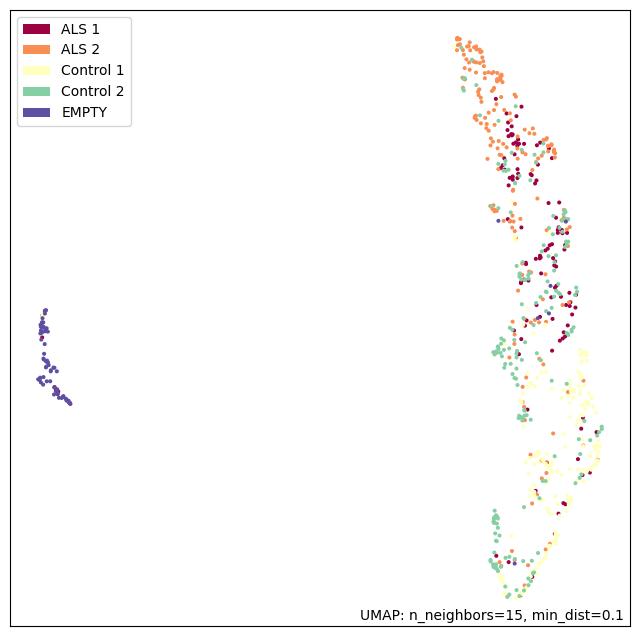

In [14]:
umap.plot.points(mapper, labels=df_agg["Cell Type"])

In [ ]:
vert = np.argsort(mapper.embedding_[:, 1])
horiz = np.argsort(mapper.embedding_[:, 0])

bottom, top = vert[0], vert[-1]
left, right = horiz[0], horiz[-1]

ax = umap.plot.points(mapper, labels=df_agg["Cell Type"])
for extreme in [bottom, top, left, right]:
    ax.scatter(mapper.embedding_[extreme, 0], mapper.embedding_[extreme, 1], c="blue")
print(df_agg.iloc[top, :]["ID"])
plt.show()

## Get remote info

In [ ]:
id_to_path_im_0 = get_id_to_path(
    "/imagestore/Aneesh/Assay Dev 20230329/BR00142687__2024-03-29T18_18_57-Measurement 1/Images/",
    tag=".tif",
    remote=True,
)
id_to_path_seg_0 = get_id_to_path(
    "/imagestore/Aneesh/Assay Dev 20230329/BR00142687__2024-03-29T18_18_57-Measurement 1/segmentations/",
    tag=".tif",
    remote=True,
)

id_to_path_im_1 = get_id_to_path(
    "/imagestore/Aneesh/Assay Dev 20230329/BR00142688__2024-03-29T19_57_13-Measurement 1/Images/",
    tag=".tif",
    remote=True,
)
id_to_path_seg_1 = get_id_to_path(
    "/imagestore/Aneesh/Assay Dev 20230329/BR00142688__2024-03-29T19_57_13-Measurement 1/segmentations/",
    tag=".tif",
    remote=True,
)

In [ ]:
def plot(id, id_to_path_im, id_to_path_seg):
    paths_ims = id_to_path_im[0][id]
    paths_segs = id_to_path_seg[0][id]

    images = read_ims(paths_ims, sftp_client=id_to_path_im[1])
    segs = read_ims(paths_segs, sftp_client=id_to_path_seg[1])

    image_dna = images[channels.index("DNA")].astype("float") / (2**16 - 1)
    image_dna_adj = exposure.equalize_adapthist(
        image_dna, clip_limit=0.03, kernel_size=[s // 64 for s in image_dna.shape]
    )
    image_rna = images[channels.index("RNA")].astype("float") / (2**16 - 1)
    image_rna_adj = exposure.equalize_adapthist(image_rna, clip_limit=0.03)
    image_agp = images[channels.index("AGP")].astype("float") / (2**16 - 1)
    image_agp_adj = exposure.equalize_adapthist(image_agp, clip_limit=0.03)
    image_rgb = np.stack([image_agp, image_rna, image_dna], axis=2)
    image_rgb_adj = np.stack([image_agp_adj, image_rna_adj, image_dna_adj], axis=2)

    seg_cell, seg_soma, seg_nuc = segs
    seg_cyto = np.logical_and(seg_soma > 0, seg_nuc == 0)

    seg_cell_masked = np.ma.masked_array(seg_cell, mask=seg_cell == 0)
    seg_soma_masked = np.ma.masked_array(seg_soma, mask=seg_soma == 0)
    seg_nuc_masked = np.ma.masked_array(seg_nuc, mask=seg_nuc == 0)
    seg_cyto_masked = np.ma.masked_array(seg_cyto, mask=seg_cyto == 0)

    f, axs = plt.subplots(nrows=1, ncols=3, dpi=300)

    axs[0].imshow(image_rgb, cmap="gray")
    axs[0].set_title(f"Image {id}")
    axs[1].imshow(image_rgb_adj, cmap="gray")
    axs[2].imshow(image_dna, cmap="gray")
    axs[2].imshow(seg_cell_masked % 20, cmap="tab20", alpha=0.5)
    axs[2].imshow(seg_cyto_masked, cmap="Accent", alpha=0.7)
    axs[2].imshow(seg_nuc_masked > 0, cmap="Set1", alpha=0.7)

    for ax in axs.flatten():
        ax.axis("off")

## Plot extremes

In [ ]:
for extreme in vert[-5:]:
    well = df_agg.iloc[extreme, :]["Well"]
    id = df_agg.iloc[extreme, :]["ID"]
    print(df_agg.iloc[extreme, :]["Cell Type"])
    print(well)
    if well[0] == 0:
        plot(id, id_to_path_im_0, id_to_path_seg_0)
    elif well[0] == 1:
        plot(id, id_to_path_im_1, id_to_path_seg_1)

In [ ]:
for extreme in vert[:5]:
    well = df_agg.iloc[extreme, :]["Well"]
    id = df_agg.iloc[extreme, :]["ID"]
    print(df_agg.iloc[extreme, :]["Cell Type"])
    print(well)
    if well[0] == 0:
        plot(id, id_to_path_im_0, id_to_path_seg_0)
    elif well[0] == 1:
        plot(id, id_to_path_im_1, id_to_path_seg_1)

In [ ]:
for extreme in [bottom, top, left, right]:
    well = df_agg.iloc[extreme, :]["Well"]
    id = df_agg.iloc[extreme, :]["ID"]
    if well[0] == 0:
        plot(id, id_to_path_im_0, id_to_path_seg_0)
    elif well[0] == 1:
        plot(id, id_to_path_im_1, id_to_path_seg_1)

# Individual Cells

In [5]:
data_soma_path = [
    "/Users/thomasathey/Documents/shavit-lab/fraenkel/first-sample/Assay Dev 20230329/BR00142687__2024-03-29T18_18_57-Measurement 1/stats/Somas.csv"
]

data_nuc_path = [
    "/Users/thomasathey/Documents/shavit-lab/fraenkel/first-sample/Assay Dev 20230329/BR00142687__2024-03-29T18_18_57-Measurement 1/stats/Nuclei.csv"
]

In [6]:
feats_to_exclude = [
    "Metadata_Series",
    "Metadata_Site",
    "Metadata_Well",
    "Metadata_WellColumn",
    "Metadata_WellRow",
    "AreaShape_Orientation",
    "AreaShape_BoundingBoxMaximum_X",
    "AreaShape_BoundingBoxMaximum_Y",
    "AreaShape_BoundingBoxMinimum_X",
    "AreaShape_BoundingBoxMinimum_Y",
    "AreaShape_Center_X",
    "AreaShape_Center_Y",
    "Children_Cytoplasm_Count",
    "Location_CenterMassIntensity_X_scaled_AGP",
    "Location_CenterMassIntensity_Y_scaled_AGP",
    "Location_CenterMassIntensity_Z_scaled_AGP",
    "Location_CenterMassIntensity_X_scaled_DNA",
    "Location_CenterMassIntensity_Y_scaled_DNA",
    "Location_CenterMassIntensity_Z_scaled_DNA",
    "Location_CenterMassIntensity_X_scaled_ER",
    "Location_CenterMassIntensity_Y_scaled_ER",
    "Location_CenterMassIntensity_Z_scaled_ER",
    "Location_CenterMassIntensity_X_scaled_mito",
    "Location_CenterMassIntensity_Y_scaled_mito",
    "Location_CenterMassIntensity_Z_scaled_mito",
    "Location_CenterMassIntensity_X_scaled_RNA",
    "Location_CenterMassIntensity_Y_scaled_RNA",
    "Location_CenterMassIntensity_Z_scaled_RNA",
    "Location_MaxIntensity_X_scaled_DNA",
    "Location_MaxIntensity_X_scaled_AGP",
    "Location_MaxIntensity_X_scaled_mito",
    "Location_MaxIntensity_X_scaled_ER",
    "Location_Center_X",
    "Location_Center_Y",
    "Location_MaxIntensity_X_scaled_RNA",
    "Location_MaxIntensity_Y_scaled_DNA",
    "Location_MaxIntensity_Y_scaled_AGP",
    "Location_MaxIntensity_Y_scaled_mito",
    "Location_MaxIntensity_Y_scaled_ER",
    "Location_MaxIntensity_Y_scaled_RNA",
    "Location_MaxIntensity_Z_scaled_DNA",
    "Location_MaxIntensity_Z_scaled_AGP",
    "Location_MaxIntensity_Z_scaled_mito",
    "Location_MaxIntensity_Z_scaled_ER",
    "Location_MaxIntensity_Z_scaled_RNA",
    "Neighbors_AngleBetweenNeighbors_Adjacent",
    "Neighbors_AngleBetweenNeighbors_25",
    "Neighbors_FirstClosestObjectNumber_Adjacent",
    "Neighbors_SecondClosestObjectNumber_Adjacent",
    "Number_Object_Number",
    "Parent_EdgeNuclei",
    "Parent_Nuclei",
    "Neighbors_FirstClosestObjectNumber_25",
    "Neighbors_SecondClosestObjectNumber_25",
]


def include_feat(feat_name):
    if (
        "Texture" not in feat_name
        and "AreaShape" not in feat_name
        and "Intensity" not in feat_name
    ):
        return False
    for feat_to_exclude in feats_to_exclude:
        if feat_to_exclude in feat_name:
            return False
    return True

In [7]:
dfs = []
for i, data_path in enumerate(data_soma_path):
    df = pd.read_csv(data_path)

    object = [item for item in list(df["ObjectNumber"])]
    col = [item for item in list(df["Metadata_WellColumn"])]
    row = [item for item in list(df["Metadata_WellRow"])]
    well = [(i, r, c) for r, c in zip(row, col)]
    field = [item for item in list(df["Metadata_Site"])]
    id = [
        f"r{str(r).zfill(2)}c{str(c).zfill(2)}f{str(f).zfill(2)}p01"
        for r, c, f in zip(row, col, field)
    ]

    df["Plate"] = i
    df["Row"] = row
    df["Column"] = col
    df["Well"] = well
    df["Field"] = field
    df["Object"] = object
    df["ID"] = id

    col_names = list(df.columns)
    col_names = [col_name for col_name in col_names if include_feat(col_name)]
    print(f"{len(col_names)} different features")
    col_names += ["Plate", "Row", "Column", "Well", "Field", "Object", "ID"]
    dfs.append(df[col_names])
df_somas = pd.concat(dfs, axis="rows")

dfs = []
for i, data_path in enumerate(data_nuc_path):
    df = pd.read_csv(data_path)

    object = [item for item in list(df["ObjectNumber"])]
    col = [item for item in list(df["Metadata_WellColumn"])]
    row = [item for item in list(df["Metadata_WellRow"])]
    well = [(i, r, c) for r, c in zip(row, col)]
    field = [item for item in list(df["Metadata_Site"])]
    id = [
        f"r{str(r).zfill(2)}c{str(c).zfill(2)}f{str(f).zfill(2)}p01"
        for r, c, f in zip(row, col, field)
    ]

    df["Plate"] = i
    df["Row"] = row
    df["Column"] = col
    df["Well"] = well
    df["Field"] = field
    df["Object"] = object
    df["ID"] = id

    col_names = list(df.columns)
    col_names = [col_name for col_name in col_names if include_feat(col_name)]
    print(f"{len(col_names)} different features")
    col_names += ["Plate", "Row", "Column", "Well", "Field", "Object", "ID"]
    dfs.append(df[col_names])
df_nucs = pd.concat(dfs, axis="rows")

766 different features
383 different features


In [10]:
df_conditions = pd.read_excel(
    "/Users/thomasathey/Documents/shavit-lab/fraenkel/first-sample/Assay Dev 20230329/Answer ALS_Pilot2_March2024.xlsx"
)
df_conditions = df_conditions.iloc[:16, 2:]

data_dmso = []
data_autophagy = []
data_verdinexor = []
data_h2o2 = []
data_tunicamycin = []
data_importazole = []
data_celltype = []

for i, row in tqdm(df_somas.iterrows()):
    r = row["Row"] - 1
    c = row["Column"] - 1
    p = row["Plate"]

    condition = df_conditions.iloc[r, c]

    if c % 6 == 0:
        data_dmso.append(1)
        data_autophagy.append(0)
        data_verdinexor.append(0)
        data_h2o2.append(0)
        data_tunicamycin.append(0)
        data_importazole.append(0)
    elif c % 6 == 1:
        data_dmso.append(0)
        data_autophagy.append(1)
        data_verdinexor.append(0)
        data_h2o2.append(0)
        data_tunicamycin.append(0)
        data_importazole.append(0)
    elif c % 6 == 2:
        data_dmso.append(0)
        data_autophagy.append(0)
        data_verdinexor.append(float(condition))
        data_h2o2.append(0)
        data_tunicamycin.append(0)
        data_importazole.append(0)
    elif c % 6 == 3:
        data_dmso.append(0)
        data_autophagy.append(0)
        data_verdinexor.append(0)
        data_h2o2.append(float(condition))
        data_tunicamycin.append(0)
        data_importazole.append(0)
    elif c % 6 == 4:
        data_dmso.append(0)
        data_autophagy.append(0)
        data_verdinexor.append(0)
        data_h2o2.append(0)
        data_tunicamycin.append(float(condition))
        data_importazole.append(0)
    elif c % 6 == 5:
        data_dmso.append(0)
        data_autophagy.append(0)
        data_verdinexor.append(0)
        data_h2o2.append(0)
        data_tunicamycin.append(0)
        data_importazole.append(float(condition))

    if p == 0:
        if (r < 8 and c < 6) or (r >= 8 and c >= 18):
            data_celltype.append("Control 1")
        elif (r < 8 and c >= 6 and c < 12) or (r >= 8 and c < 6):
            data_celltype.append("ALS 1")
        elif (r < 8 and c >= 18) or (r >= 8 and c < 18 and c >= 12):
            data_celltype.append("Control 2")
        else:
            data_celltype.append("ALS 2")
    elif p == 1:
        if (r < 8 and c < 6) or (r >= 8 and c >= 18):
            data_celltype.append("ALS 2")
        elif (r < 8 and c >= 6 and c < 12) or (r >= 8 and c < 6):
            data_celltype.append("Control 2")
        elif (r < 8 and r >= 6 and c >= 18) or (
            r >= 8 and r < 10 and c < 18 and c >= 12
        ):
            data_celltype.append("ALS 1")
        elif (r < 8 and c >= 12 and c < 18) or (r >= 8 and c < 12 and c >= 6):
            data_celltype.append("Control 1")
        else:
            data_celltype.append("EMPTY")


data = {
    "DMSO": data_dmso,
    "Autophagy": data_autophagy,
    "Verdinexor": data_verdinexor,
    "H2O2": data_h2o2,
    "Tunicamysin": data_tunicamycin,
    "Importazole": data_importazole,
    "Cell Type": data_celltype,
}
df_covariates = pd.DataFrame(data)

455991it [01:23, 5453.42it/s] 


In [11]:
# why do we need this?
df_covariates.reset_index(drop=True, inplace=True)
df_somas.reset_index(drop=True, inplace=True)

In [12]:
df = pd.concat((df_somas, df_covariates), axis="columns")

#### Check that labels are consecutive

In [112]:
id_to_obj = {}
for i, row in tqdm(df_nucs.iterrows()):
    id = row["ID"]
    obj = row["Object"]

    if id in id_to_obj.keys():
        new = id_to_obj[id] + [obj]
        id_to_obj[id] = new
    else:
        id_to_obj[id] = [obj]

for key, val in id_to_obj.items():
    if sorted(val) == list(range(min(val), max(val) + 1)):
        pass
    else:
        print((key, val))

425508it [00:39, 10812.34it/s]


In [118]:
obj_id_soma = [f"{id}-{obj}" for obj, id in zip(list(df["Object"]), list(df["ID"]))]
obj_id_nuc = [
    f"{id}-{obj}" for obj, id in zip(list(df_nucs["Object"]), list(df_nucs["ID"]))
]
assert len(obj_id_soma) == len(set(obj_id_soma))
assert len(obj_id_nuc) == len(set(obj_id_nuc))

for id in obj_id_soma:
    if id not in obj_id_nuc:
        print(id)
        break

r01c01f02p01-246


In [120]:
id_to_path_im_0 = get_id_to_path(
    "/imagestore/Aneesh/Assay Dev 20230329/BR00142687__2024-03-29T18_18_57-Measurement 1/Images/",
    tag=".tif",
    remote=True,
)
id_to_path_seg_0 = get_id_to_path(
    "/imagestore/Aneesh/Assay Dev 20230329/BR00142687__2024-03-29T18_18_57-Measurement 1/segmentations/",
    tag=".tif",
    remote=True,
)

id_to_path_im_1 = get_id_to_path(
    "/imagestore/Aneesh/Assay Dev 20230329/BR00142688__2024-03-29T19_57_13-Measurement 1/Images/",
    tag=".tif",
    remote=True,
)
id_to_path_seg_1 = get_id_to_path(
    "/imagestore/Aneesh/Assay Dev 20230329/BR00142688__2024-03-29T19_57_13-Measurement 1/segmentations/",
    tag=".tif",
    remote=True,
)

In [134]:
paths_segs = id_to_path_seg_0[0]["r01c01f01p01"]
segs = read_ims(paths_segs, sftp_client=id_to_path_seg_0[1])

In [140]:
np.unique(segs[0], return_counts=True)

(array([  0,   1,   6,   8,  10,  11,  13,  14,  15,  17,  20,  25,  30,
         31,  33,  34,  35,  36,  37,  41,  46,  48,  49,  51,  52,  53,
         55,  56,  57,  58,  59,  60,  61,  63,  64,  66,  67,  69,  71,
         76,  78,  81,  82,  83,  85,  88,  89,  90,  91,  92,  93, 101,
        102, 105, 106, 108, 110, 111, 113], dtype=int32),
 array([1081925,     121,    1059,     377,    4004,     313,    1201,
            733,    1799,    3719,   12583,     329,     497,     282,
           8920,     630,    3665,    8134,    5765,     304,     746,
            459,     357,     175,     201,     451,     752,     665,
            192,     397,     660,     735,     423,    1986,     523,
            613,     321,     374,    1136,    2899,     359,     187,
           2133,    1609,    1189,    1148,     446,     689,     374,
           1602,     890,     336,    2739,     485,     177,     167,
            368,     802,     275]))

## Compute distance matrix

In [20]:
agg = True

col_names = list(df.columns)
col_names = [col_name for col_name in col_names if include_feat(col_name)]
print(len(col_names))

if agg:
    aggregation_functions = {k: "mean" for k in list(df.columns) if include_feat(k)}
    aggregation_functions_2 = {
        k: "first" for k in list(df.columns) if not include_feat(k)
    }
    aggregation_functions.update(aggregation_functions_2)
    df = df.groupby(df["Well"]).aggregate(aggregation_functions)

    df.sort_values(by=["Cell Type"], inplace=True)

    df_feats = df[col_names]
else:
    df = df.sample(n=10000)
    df_feats = df[col_names]

766


In [21]:
feats = df_feats.to_numpy()
print(f"Fraction of finite feature values: {np.sum(np.isfinite(feats))/feats.size}")
feats = np.nan_to_num(feats, nan=0.0, posinf=0.0, neginf=0.0)
D = pairwise_distances(feats, metric="cosine")

Fraction of finite feature values: 0.9996736292428199


## Plot distance matrix

<Axes: >

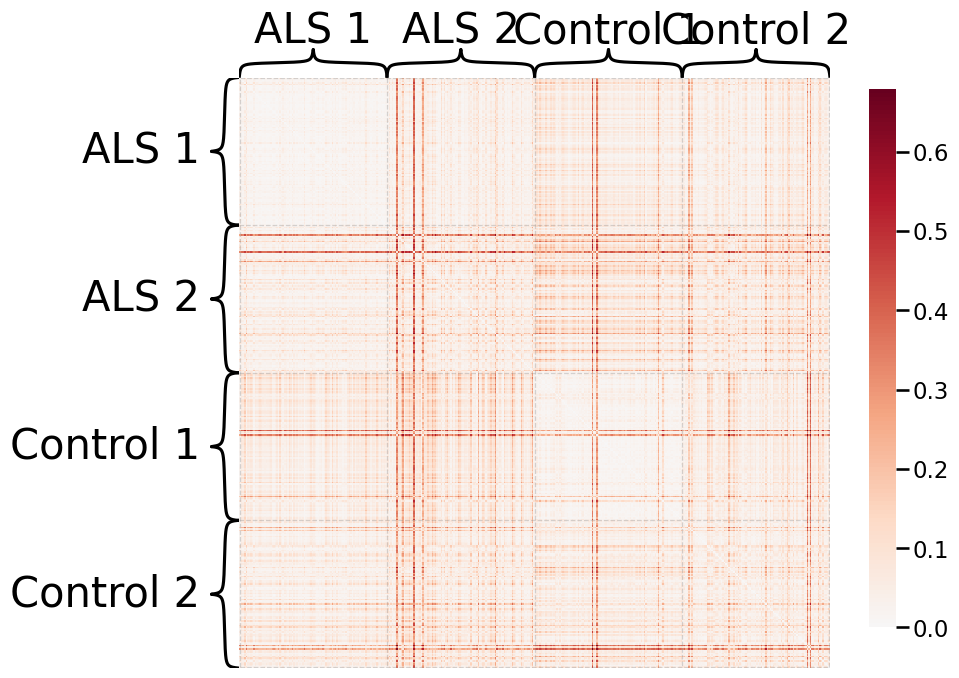

In [22]:
heatmap(D, inner_hier_labels=df["Cell Type"])

In [23]:
np.save(
    "/Users/thomasathey/Documents/shavit-lab/fraenkel/cell_paint_seg/experiments/D_av.npy",
    D,
)

df.to_csv(
    "/Users/thomasathey/Documents/shavit-lab/fraenkel/cell_paint_seg/experiments/df_av.csv"
)

In [ ]:
import umap
import pandas as pd
import numpy as np
import pickle

df = pd.read_csv(
    "/Users/thomasathey/Documents/shavit-lab/fraenkel/cell_paint_seg/experiments/df_av.csv"
)
D = np.load(
    "/Users/thomasathey/Documents/shavit-lab/fraenkel/cell_paint_seg/experiments/D_av.npy",
)
mapper = umap.UMAP().fit(D)
with open(
    "/Users/thomasathey/Documents/shavit-lab/fraenkel/cell_paint_seg/experiments/mapper.pickle",
    "wb",
) as handle:
    pickle.dump(mapper, handle)

In [24]:
with open(
    "/Users/thomasathey/Documents/shavit-lab/fraenkel/cell_paint_seg/experiments/mapper.pickle",
    "rb",
) as file:
    mapper = pickle.load(file)

# mapper = umap.UMAP().fit(D)

<Axes: >

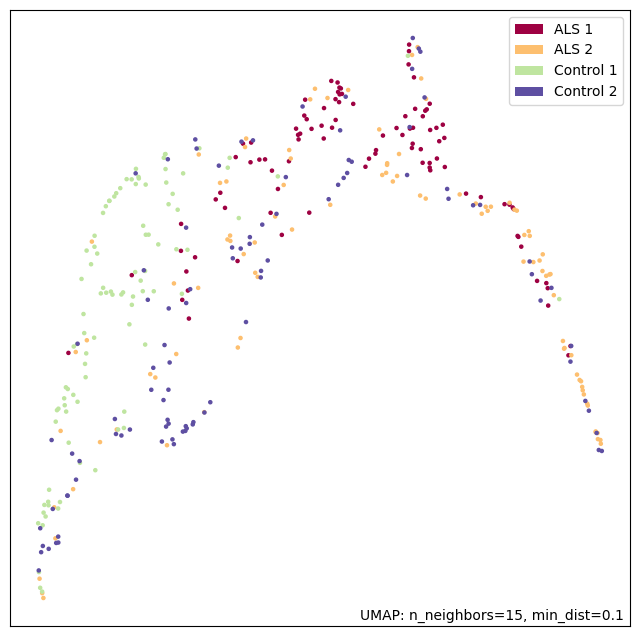

In [25]:
umap.plot.points(mapper, labels=df["Cell Type"])

# Plot results

In [ ]:
data_mean = df_means.to_numpy()
data_mean = np.nan_to_num(data_mean)
# data_mean = [row for row, f in zip(data_mean, field) if f != 5]
D = pairwise_distances(data_mean, metric="cosine")

lim = 9 * 10
plt.imshow(D[:lim, :lim])
plt.colorbar()

for i in np.arange(0, lim, 9):
    plt.plot([0, lim], [i - 0.5, i - 0.5], "r--", linewidth=0.5)
    plt.plot([i - 0.5, i - 0.5], [0, lim], "r--", linewidth=0.5)

plt.title("Feature Cosine Distances between Images (First 90)")
plt.xticks([])
plt.yticks([])

In [ ]:
data_dist = []
data_type = []
data_ids = []
for i in range(D.shape[0]):
    tile1 = i // 9
    for j in range(i):
        tile2 = j // 9
        data_dist.append(D[i, j])
        data_ids.append((id[i], id[j]))
        if tile1 == tile2:
            data_type.append("Same")
        else:
            data_type.append("Different")

df_types = pd.DataFrame(
    data={"Distance": data_dist, "Well Relationship": data_type, "ID Pair": data_ids}
)
sns.boxplot(df_types, x="Distance", y="Well Relationship")

x = df_types[df_types["Well Relationship"] == "Same"]["Distance"].to_numpy()
y = df_types[df_types["Well Relationship"] == "Different"]["Distance"].to_numpy()
res = mannwhitneyu(x, y, alternative="less")
plt.title(
    f"Inter vs. Intrawell Feature Distances (Mann-Whitney p-val: {res.pvalue :.2E})"
)

In [ ]:
df_outliers = df_types[
    (df_types["Well Relationship"] == "Same") & (df_types["Distance"] > 0.5)
]
for pair in df_outliers["ID Pair"]:
    plot(pair[0], id_to_path_im, id_to_path_seg)
    plt.show()
    plot(pair[1], id_to_path_im, id_to_path_seg)
    plt.show()
    print("**")

# Cell Type Distances

In [ ]:
data_dist = []
data_type = []
data_ids = []
for i in range(D.shape[0]):
    type1 = cell_types[i]
    for j in range(i):
        type2 = cell_types[j]
        data_dist.append(D[i, j])
        data_ids.append((id[i], id[j]))
        if type1 == type2:
            data_type.append("Same")
        else:
            data_type.append("Different")

df_types = pd.DataFrame(
    data={
        "Distance": data_dist,
        "Cell Type Relationship": data_type,
        "ID Pair": data_ids,
    }
)
sns.boxplot(df_types, x="Distance", y="Cell Type Relationship")

x = df_types[df_types["Cell Type Relationship"] == "Same"]["Distance"].to_numpy()
y = df_types[df_types["Cell Type Relationship"] == "Different"]["Distance"].to_numpy()
res = mannwhitneyu(x, y, alternative="less")
plt.title(
    f"Inter vs. Intrawell Feature Distances (Mann-Whitney p-val: {res.pvalue :.2E})"
)

# Intrawell distances

In [ ]:
data_dist = []
data_type = []

D_tile = np.zeros((9, 9, D.shape[0] // 9))
for i in range(D.shape[0]):
    tile1 = i // 9
    for j in range(i):
        tile2 = j // 9
        if tile1 == tile2:
            f1 = i % 9
            f2 = j % 9
            D_tile[f1, f2, tile1] = D[i, j]


D_tile2 = np.zeros((9, (D.shape[0] // 9) * 8))
for field in range(D_tile2.shape[0]):
    distances = []
    for i in range(1, D_tile.shape[0]):
        for j in range(i):
            if i == field or j == field:
                distances += list(D_tile[i, j, :])

    D_tile2[field, :] = distances

dfs = []
for field in range(D_tile2.shape[0]):
    df = pd.DataFrame({"Distance": D_tile2[field, :]})
    df["Field"] = str(field)
    dfs.append(df)
df = pd.concat(dfs)

sns.boxplot(df, x="Distance", y="Field")
plt.title("Distances from Other Fields of Same Well")

# # f, axs = plt.subplots(nrows=9, ncols=9)
# # for i, row in enumerate(axs):
# #     for j, ax in enumerate(row):
# #         sns.histplot(D_tile[i,j,:], ax=ax)
# #         ax.set_xlim(left=0, right=1)

# # f.set_size_inches(20,20)

# f, axs = plt.subplots(ncols=9)
# for i, ax in enumerate(axs):
#     sns.histplot(D_tile2[i,:], ax=ax)
#     ax.set_xlim(left=0, right=1)
# f.set_size_inches(15,5)